In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import xgboost as xgb


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
# Load Data
df_hot = pd.read_csv('Kivela - Final Exam Preprocessed.csv')

In [3]:
# Define Variables
TargetVariable = 'Credit_Mix'

X = df_hot.drop(columns = TargetVariable)
y = df_hot[TargetVariable]

In [4]:
# split the data into training and validation
train_X, valid_X, train_y, valid_y = train_test_split(X, 
                                                      y, 
                                                      test_size = 0.3, 
                                                      train_size = 0.7, 
                                                      random_state = 373,
                                                      # stratify = y
                                                     )

In [5]:
# Create a boosted tree model
clf_xgb = GradientBoostingClassifier(
                                     #loss="log_loss", 
                                     #learning_rate=0.1, 
                                     n_estimators = 10, 
                                     #subsample=1.0, 
                                     #criterion="friedman_mse", 
                                     #min_samples_split=2, 
                                     #min_samples_leaf=1, 
                                     #min_weight_fraction_leaf=0.0, 
                                     #max_depth=3, 
                                     #min_impurity_decrease=0.0, 
                                     #init=None, 
                                     random_state = 373, 
                                     #max_features=None, 
                                     verbose = 0, 
                                     #max_leaf_nodes=None, 
                                     #warm_start=False, 
                                     #validation_fraction=0.1, 
                                     n_iter_no_change = 10, 
                                     #tol=1e-4, 
                                     #ccp_alpha=0.0
                                     )

In [6]:
# Fit (train) the model
clf_xgb.fit(X = train_X,
            y = train_y,
            #sample_weight=None,
            #check_input=True
            )

GradientBoostingClassifier(n_estimators=10, n_iter_no_change=10,
                           random_state=373)

In [7]:
# Set some names
FeatureNames = list(valid_X.columns)
ClassNames = list(clf_xgb.classes_)

In [8]:
# Cross-validation on the training set
cv_scores = cross_val_score(clf_xgb, X, y, cv=5)

print("Cross-validation scores on training set:", cv_scores)
print("Mean CV accuracy on training set:", cv_scores.mean())
# CV accuracy = estimate of how well the model generalizes to new data.

Cross-validation scores on training set: [0.91292449 0.91043662 0.91877099 0.9108098  0.91155616]
Mean CV accuracy on training set: 0.9128996143798981


                          feature    importance       std
11       Credit_Utilization_Ratio -3.602334e-16  0.088093
13        Amount_invested_monthly  0.000000e+00  0.088093
5                     Num_of_Loan  0.000000e+00  0.088093
9            Num_Credit_Inquiries  0.000000e+00  0.088093
12            Total_EMI_per_month  1.177710e-10  0.088093
14                Monthly_Balance  3.082748e-08  0.088093
0                   Annual_Income  1.675106e-05  0.088093
1           Monthly_Inhand_Salary  1.945668e-05  0.088093
17  Payment_of_Min_Amount_Unknown  1.023866e-03  0.088093
3                 Num_Credit_Card  1.223253e-03  0.088093
8            Changed_Credit_Limit  3.310977e-02  0.088093
6             Delay_from_due_date  5.069399e-02  0.088093
16     Payment_of_Min_Amount_True  5.808556e-02  0.088093
2               Num_Bank_Accounts  8.944081e-02  0.088093
7          Num_of_Delayed_Payment  1.009003e-01  0.088093
4                   Interest_Rate  1.116872e-01  0.088093
15    Payment_

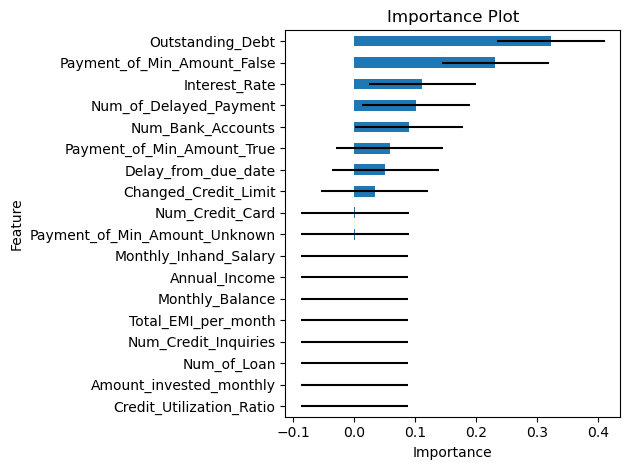

In [9]:
## Variable/Feature Importance Plot Data Frame
importances = clf_xgb.feature_importances_

# Get standard deviation
std = np.std(importances, 
             axis = 0, 
             dtype=None, 
             out=None, 
             ddof=0, 
             keepdims=False,
             # where=None
             )

# Describe Importances
importance_plot_df = pd.DataFrame({'feature': FeatureNames, 
                                   'importance': importances, 
                                   'std': std})

importance_plot_df = importance_plot_df.sort_values('importance')

print(importance_plot_df)

## Importance Plot
ax = importance_plot_df.plot(kind='barh', 
                             xerr='std', 
                             x='feature', 
                             legend=False)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Importance Plot')
plt.tight_layout()
plt.show()

In [10]:
# Hyperparameter optimization

# Initial Parameter grid tuning
param_grid = {
    'n_estimators': [0, 10],
    'min_samples_split': [5, 10],
    'max_depth': [3, 5, 7],
    'min_impurity_decrease': [0.0, 0.1, 0.2],
    'random_state': [373],
}

In [11]:
# Trying a randomized search instead of gridsearch cuz it keeps crashing
rand = RandomizedSearchCV(clf_xgb,
                         param_grid,
                         n_iter = 1,
                         cv = 3,
                         scoring = 'accuracy',
                         random_state = 373)

# Fit the randomized cv
rand.fit(X, y)

# Print best parameters and best score
print('Initial score: ', rand.best_score_)
print('Initial parameters: ', rand.best_params_)

Initial score:  0.913695712149534
Initial parameters:  {'random_state': 373, 'n_estimators': 10, 'min_samples_split': 10, 'min_impurity_decrease': 0.1, 'max_depth': 3}


In [12]:
# Updated Parameter grid tuning (wash, rinse, repeat)
param_grid = {
    'n_estimators': [75],
    'min_samples_split': [100],
    'max_depth': [4],
    'min_impurity_decrease': [0.1],
    'random_state': [373],
}

In [13]:
# Cross Validation (Wash, Rinse, Repeat)
rand = RandomizedSearchCV(clf_xgb,
                         param_grid,
                         n_iter = 3,
                         cv = 3,
                         scoring = 'accuracy',
                         random_state = 373)

# Fit the randomized cv
rand.fit(X, y)

# Print best parameters and best score
print('Best score: ', rand.best_score_)
print('Best parameters: ', rand.best_params_)

C:\Users\KGLtd\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=3. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best score:  0.9366836107213027
Best parameters:  {'random_state': 373, 'n_estimators': 75, 'min_samples_split': 100, 'min_impurity_decrease': 0.1, 'max_depth': 4}


In [14]:
# Evaluate the final model on validatoipn data
best_clf = rand.best_estimator_
y_pred = best_clf.predict(valid_X)
valid_accuracy = best_clf.score(valid_X, valid_y)

print("Accuracy on validation set:", valid_accuracy)

Accuracy on validation set: 0.9499129281034911


Classification Report:
              precision    recall  f1-score   support

         Bad       0.96      0.97      0.96      2819
        Good       0.95      0.95      0.95      3718
    Standard       0.95      0.94      0.95      5522

    accuracy                           0.95     12059
   macro avg       0.95      0.95      0.95     12059
weighted avg       0.95      0.95      0.95     12059

Confusion Matrix:
[[2736    0   83]
 [   0 3518  200]
 [ 122  199 5201]]


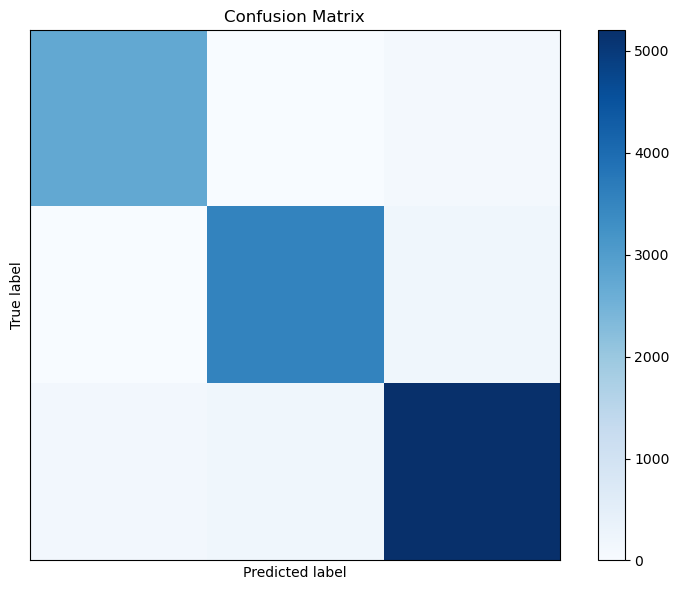

In [15]:
# Classification report
print("Classification Report:")
print(classification_report(valid_y, y_pred, target_names=ClassNames))

# Confusion matrix
print("Confusion Matrix:")
conf_mat = confusion_matrix(valid_y, y_pred)
print(conf_mat)


# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

# Store confusion matrix in variable conf_mat
conf_mat = plt

plt.show()